In [1]:
import pandas as pd
import numpy as np
import os
import enchant
import re
import warnings
import matplotlib.pyplot as plt
import itertools
import math
warnings.simplefilter('ignore')

In [170]:
year = "2019"
filepath = "C:/Users/mlmcp/stopa/data/"
df_list = [pd.read_parquet(filepath+year+"_parquet_logs/"+file) for file in os.listdir(filepath+year+"_parquet_logs/")]
df = pd.concat(df_list, ignore_index=True)

In [171]:
# Manual 2019

# Manually merge 'Di' with '$p' (2019)
row = df[df['text']=='$p-13:30:00'].index[0]
df.at[row, 'text'] = 'Disp-13:30:00'
df.drop([row-1],inplace=True)
df.reset_index(drop=True,inplace=True)

# Manually fix 'Arvd-13:368:23' (2019)
row = df[df['text']=='Arvd-13:368:23'].index[0]
df.at[row,'text'] = 'Arvd-13:36:23'

# Manually fix 'Axyvd-160:19:35' (2019) (Clrd-10:27:04) # df[df['text'].str.startswith('Axyvd-1')]
row = df[df['text']=='Axyvd-160:19:35'].index[0]
df.at[row,'text'] = 'Axyvd-10:19:35'

# Manually fix 'Arvd-17:15:31)' (2019)
row = df[df['text']=='Arvd-17:15:31)'].index[0]
df.at[row,'text'] = 'Arvd-17:15:31'

In [172]:
# Clrd-date // @ // time
pattern_date = re.compile("\d\d/\d\d/\d\d\d\d")
pattern_time = re.compile("\d\d+[:;]+\d\d+[:;]+\d\d+")

df['text2'] = df['text']
df['drop']=0

for i in range(len(df)):
    if pattern_date.search(df['text'][i]): # Checks for date anywhere in text
        if enchant.utils.levenshtein(re.sub(pattern_date,"",df['text'][i]),'Clrd-')<=2: # Find prefix similar to 'Clrd-'
            if (pattern_time.fullmatch(df['text'][i+2])) and (len(df['text'][i+1])==1): # [i+2] is a timestamp and [i+1] looks like @
                df['text2'][i] = 'Clrd-'+pattern_time.search(df['text'][i+2]).group() # .group() returns the matching string
                df['drop'][i+1] = 1
                df['drop'][i+2]= 1

df.drop(df[df['drop'] == 1].index, inplace=True)
df.reset_index(drop=True,inplace=True)

# df[df['text']!=df['text2']]

In [173]:
# Arvd- and timestamp on sucessive rows.
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']

df['text3']=df['text2']

for i in range(len(df)-1):
    if pattern_time.fullmatch(df['text'][i+1]): # Next line is timestamp
        for w in fix_list:
            if enchant.utils.levenshtein(df['text'][i],w)<=2:
                df['text3'][i] = w+df['text'][i+1] # Merge rows
                df['drop'][i+1]=1 # Drop row
        
df.drop(df[df['drop'] == 1].index, inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop('drop', axis=1, inplace=True)

# df[df['text3']!=df['text2']]

In [174]:
# Fix word-timestamp if word is close to 'Arvd', etc.
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']

# New columns
df['text4'] = df['text3']
df['timestamp'] = ''

for i in range(len(df)):
    if pattern_time.search(df['text3'][i]): #Checks for timestamp anywhere in text
        df['timestamp'][i] = pattern_time.search(df['text3'][i])[0]
        for w in fix_list:
            if (enchant.utils.levenshtein(re.sub(pattern_time,"",df['text3'][i]),w)<=2):
                df['text4'][i] = w + pattern_time.search(df['text3'][i])[0]

# df[df['text3']!=df['text4']]
# Note - dist('Arvd','Clrd') = 3 so threshhold needs to be 2

In [175]:
# Manually fix status-timestamp

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_disp = ['$p-'] # Fixed manually above
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

df['text5']=df['text4']

for w in manual_arvd:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Arvd-')

for w in manual_clrd:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Clrd-')

for w in manual_enrt:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Enrt-')

# df[df['text5']!=df['text4']]

In [176]:
print(df[df['text5'].str.startswith('Disp-')].shape)
print(df[df['text5'].str.startswith('Enrt-')].shape)
print(df[df['text5'].str.startswith('Arvd-')].shape)
print(df[df['text5'].str.startswith('Clrd-')].shape)

(3240, 18)
(2391, 18)
(12136, 18)
(12474, 18)


In [177]:
# Make column for status word

df['status'] = '' # Will be poplulated by Disp, Enrt, Arvd, Clrd
status_list = ['Disp','Enrt','Arvd','Clrd']

for status in status_list:
    idx = df[df['text5'].str.startswith(status+'-')].index
    for i in idx:
        df['status'][i] = status

In [178]:
df.drop('text2', axis=1, inplace=True)
df.drop('text3', axis=1, inplace=True)
df.drop('text4', axis=1, inplace=True)

In [179]:
# Clean timestamp
df['timestamp'] = df['timestamp'].str.replace(';','')
df['timestamp'] = df['timestamp'].str.replace(':','')
df['timestamp'] = df['timestamp'].str[0:2]+':'+df['timestamp'].str[2:4]+':'+df['timestamp'].str[4:6]
# Note - We are not addressing timestamps that are too many digits

In [180]:
# Turn timestamps for status words (Arvd, Clrd, Enrt, Disp) into datetimes
pattern_time_clean = re.compile("\d\d:\d\d:\d\d")
df['time_clean'] = ''
for i in range(len(df)):
    if pattern_time_clean.fullmatch(df['timestamp'][i]): 
        df['time_clean'][i] = df['timestamp'][i]

df['time_clean'] = pd.to_datetime(df['time_clean'],format= '%H:%M:%S',errors='coerce') # Out of time range --> NaT

# Days

In [181]:
# Add columnm with log number
# Note - finding log time via 4 digits that fall within %H%M resulted in 17k log times.

pattern_log_num = re.compile("19-\d+") # 2019
pattern_log_time = re.compile("[012]\d[012345]\d")

df['log_num'] = ''
df['log_time'] = ''

for i in df.index:
    if pattern_log_num.fullmatch(df['text5'][i]):
        df['log_num'][i] = df['text5'][i]
        if pattern_log_time.fullmatch(df['text5'][i+1]):
            df['log_time'][i+1] = df['text5'][i+1]

In [183]:
df['log_timedt'] = pd.to_datetime(df['log_time'],format= '%H%M',errors='coerce') # Out of time range --> NaT
# df[(df['log_time']!='') & (pd.isnull(df['log_timedt']))].shape # 21 log times out of time range

# Convert time to UTC integer - Do not end up using (check)
df['log_time_int'] = pd.to_datetime(df['log_timedt'],errors='coerce').astype(np.int64)

In [185]:
# Add column with daybreak based on log time
idx = df[pd.notnull(df['log_timedt'])].index
idx1 = df[pd.notnull(df['log_timedt'])].drop(index = idx[0]).index

# We expect daybreaks to be close to 24 hours if last log of day is shortly before midnight and first log of next day is shortly after midnight. 

df['daybreak'] = 0
for (i, j) in zip(idx, idx1):
    if (df['log_timedt'][j] - df['log_timedt'][i] < pd.Timedelta(-12, "h")):
         df['daybreak'][j] = 1

df['daybreak'][idx[0]] = 1 # First log is the start of day 0

# Convert time to [0, 24]
df['log_hour']=''
for i in idx:
    df['log_hour'][i] = (df['log_timedt'][i]-pd.Timestamp("1900-01-01")).total_seconds()/3600

In [186]:
df['daybreak'].sum() # Counting 336 days, which is consistent with 365 - month missing

336

In [187]:
df['day']=0
for i in range(1,len(df)):
    df['day'][i] = df['daybreak'][i] + df['day'][i-1]
df['day'] = df['day'] - 1 # Start count at day 0
df['day'] = df['day'].replace(-1, 0)

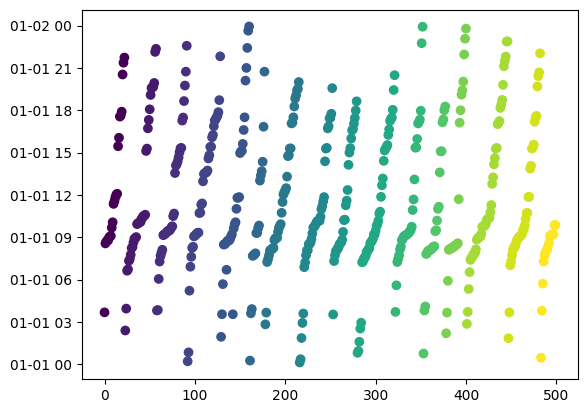

In [189]:
df_log = df[pd.notnull(df['log_timedt'])]
df_log.reset_index(drop=True,inplace=True)
plt.scatter(df_log.index[0:500],df_log['log_timedt'][0:500],c=df_log['day'][0:500])

In [2]:
# df.to_pickle(r'C:\Users\mlmcp\SToPA\data\2019_clean_text.pkl')
df = pd.read_pickle(r'C:\Users\mlmcp\SToPA\data\2019_clean_text.pkl')

# DBSCAN for Days

In [3]:
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [154]:
# https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan

In [4]:
df_log = df[(df['log_time']!='') & pd.notnull(df['log_timedt']))]
df_log.reset_index(drop=True,inplace=True)
n = 6
df_log['index']=df_log.index
df_log['log_time_int'] = pd.to_datetime(df_log['log_timedt']).astype(np.int64)
X = df_log[df_log['day']<n][['index', 'log_time_int']]
# plt.scatter(X['index'],X['log_time_int'])

In [5]:
# # Scaling the Data 
X_scaled = StandardScaler().fit_transform(X) 
  
# Normalizing the Data 
# X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_principal = pd.DataFrame(X_scaled)
  
X_principal.columns = ['index', 'log_time_int'] 

Find epsilon 

In [6]:
min_samples = 10 # 9174 log times / 336 days = ~27 average
nn = NearestNeighbors(n_neighbors=min_samples - 1) # min_samples - 1
nbrs = nn.fit(X_principal)
distances, indices = nbrs.kneighbors(X_principal)

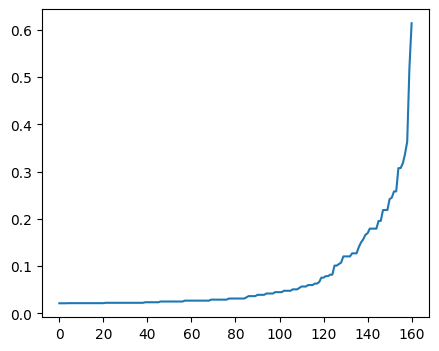

In [7]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(5,4))
plt.plot(distances)
# plt.axhline(y=0.75e12, color='r', linestyle='--', alpha=0.4) # elbow line

In [8]:
min_samples = range(5,15)
eps = np.arange(0.1,.6, 0.01) # returns array of ranging from 0.05 to 0.13 with step of 0.01

output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(X_principal).labels_
        clusters = np.unique(labels).shape[0]-1
        if clusters > 1:
            score = silhouette_score(X_principal, labels)
        else: score = -1
        n_noise = list(labels).count(-1)
        # silhouette_score for evaluating the clusters, ranges from -1 to +1, desirable score is close to 1
        output.append((ms, ep, score, clusters, n_noise))

In [4]:
# sorted(output, key=lambda x:x[2],reverse=True)

In [10]:
min_samples, eps, score, clusters, n_noise = sorted(output, key=lambda x:x[2])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")
print(f"clusters: {clusters}")
print(f"n_noise: {n_noise}")

Best silhouette_score: 0.3223914420354727
min_samples: 5
eps: 0.5299999999999998
clusters: 8
n_noise: 12


Number of noise points: 16
Number of clusters: 7


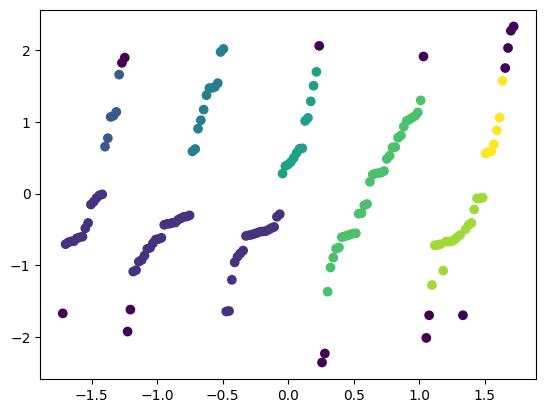

In [12]:
# Compute DBSCAN
epsilon = .53
min_samples = 5 # should be n_neighbors + 1
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X_principal)
labels = db.labels_
X_principal['labels'] = labels
n_noise = list(X_principal['labels']).count(-1)
print("Number of noise points:", n_noise)
total_labels = np.unique(labels)
n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

plt.scatter(X_principal['index'], X_principal['log_time_int'],  
           c = X_principal['labels'], cmap =plt.cm.viridis) 
plt.show() 

# Spectral for Days

In [13]:
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

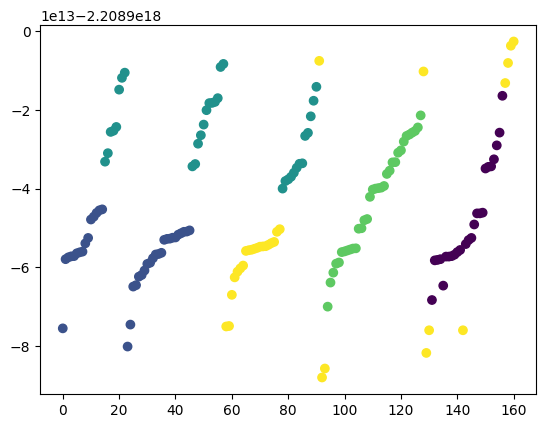

In [14]:
plt.scatter(X['index'], X['log_time_int'],  
           c = SpectralClustering(n_clusters = 5, affinity ='nearest_neighbors',n_neighbors = 15).fit_predict(X_principal),cmap =plt.cm.viridis) 
plt.show() 

# OPTICS for Days

In [ ]:
# DBSCAN has fixed eps - does not work if clusters have varying density. OPTICS treats eps as max. 
# Core distance:
# Reachability distance: 

In [15]:
import matplotlib.gridspec as gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [16]:
clust = OPTICS(min_samples=5, metric = 'euclidean',cluster_method='xi',xi=.05,min_cluster_size=5,max_eps = 1)
# clust = OPTICS(min_samples=5, metric = 'euclidean',cluster_method='dbscan',eps=.5)

clust.fit(X_principal)

labels = clust.labels_

Number of noise points: 19
Number of clusters: 14


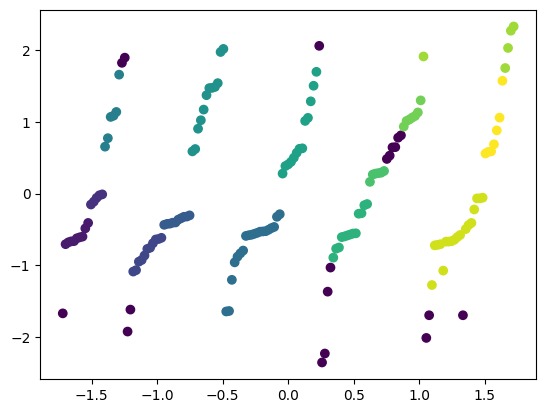

In [17]:
X_principal['labels'] = labels
n_noise = list(X_principal['labels']).count(-1)
print("Number of noise points:", n_noise)
total_labels = np.unique(labels)
n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

plt.scatter(X_principal['index'], X_principal['log_time_int'],  
           c = X_principal['labels'], cmap =plt.cm.viridis) 
plt.show() 

In [18]:
eps = np.arange(0.1,.6, 0.01) # returns array of ranging from 0.05 to 0.13 with step of 0.01

output = []

for ep in eps:
    labels = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=ep)
    clusters = np.unique(labels).shape[0]-1
    n_noise = list(labels).count(-1)
    output.append((ep, clusters, n_noise))

In [5]:
# sorted(output, key=lambda x:x[2],reverse=False)

Number of noise points: 22
Number of clusters: 9


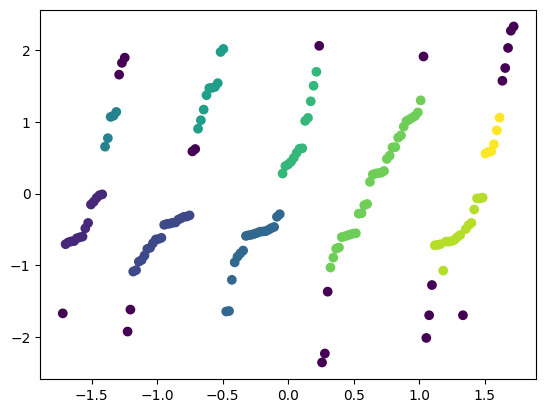

In [20]:
labels = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
X_principal['labels'] = labels
n_noise = list(X_principal['labels']).count(-1)
print("Number of noise points:", n_noise)
total_labels = np.unique(labels)
n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

plt.scatter(X_principal['index'], X_principal['log_time_int'],  
           c = X_principal['labels'], cmap =plt.cm.viridis) 
plt.show() 

# HDBSCAN for Days

In [21]:
from sklearn.cluster import HDBSCAN

Number of noise points: 34
Number of clusters: 7


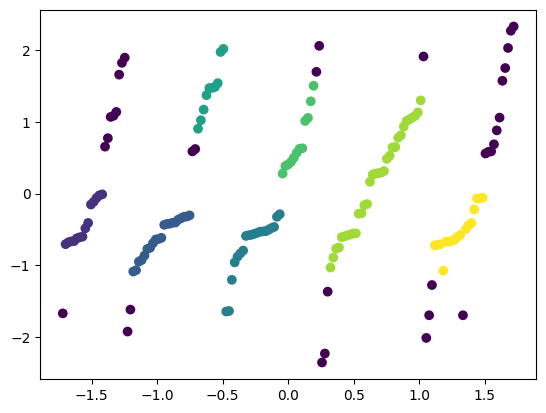

In [22]:
hdb = HDBSCAN(min_cluster_size=10)
hdb.fit(X_principal)
labels = hdb.labels_
X_principal['labels'] = labels
n_noise = list(X_principal['labels']).count(-1)
print("Number of noise points:", n_noise)
total_labels = np.unique(labels)
n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

plt.scatter(X_principal['index'], X_principal['log_time_int'],  
           c = X_principal['labels'], cmap =plt.cm.viridis) 
plt.show() 

# df_log erroneous data

In [3]:
df_log = df[pd.notnull(df['log_timedt'])]
df_log.reset_index(drop=True,inplace=True)
df_log['index']=df_log.index

In [4]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn import neighbors
from scipy.spatial.distance import pdist, squareform
import matplotlib.backends.backend_pdf

In [36]:
# Data for regression
df_regr = df_log[df_log['day']==324]
X = np.array(df_regr['index']).reshape(-1, 1)
y = np.array(df_regr['log_hour']).reshape(-1, 1)
# plt.scatter(X,y)

Mean squared error: 6.75
Coefficient of determination: 0.64


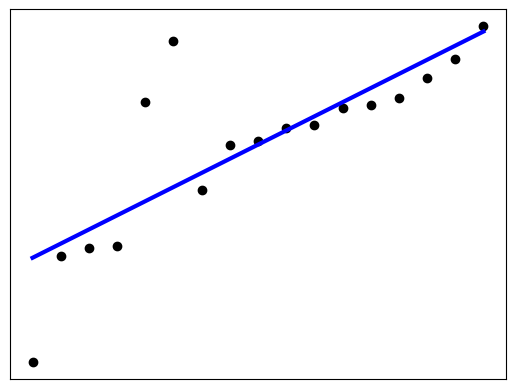

In [24]:
# Linear
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(X)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X, y, color="black")
plt.plot(X, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [43]:
# Radius Neighbors Regression

# # Option 1
# rnnregr = neighbors.RadiusNeighborsRegressor(radius=1.0, weights='uniform',metric='precomputed')

# X_dist = squareform(pdist(X), force='no', checks=True)
# X_dist[X_dist == 0 ] = 1000

# # Train the model using the training sets
# rnnregr.fit(X_dist, y)

# # Make predictions using the testing set
# y_pred = rnnregr.predict(X_dist)

# Option 2
def d(a,b):
    if a==b: dist = 1000
    else: dist = abs(a-b)
    return dist
    
rnnregr = neighbors.RadiusNeighborsRegressor(radius=1.0, weights='uniform', metric=lambda a,b: d(a,b))
# rnnregr = neighbors.RadiusNeighborsRegressor(radius=1.0, weights="uniform")

# Train the model using the training sets
rnnregr.fit(X, y)

# Make predictions using the testing set
y_pred = rnnregr.predict(X)

# Plot outputs
plt.scatter(X, y, color="black")
plt.plot(X, y_pred, color="blue", linewidth=3)
# plt.scatter(X, y_pred, color="blue")
plt.xticks(())
plt.yticks(())
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

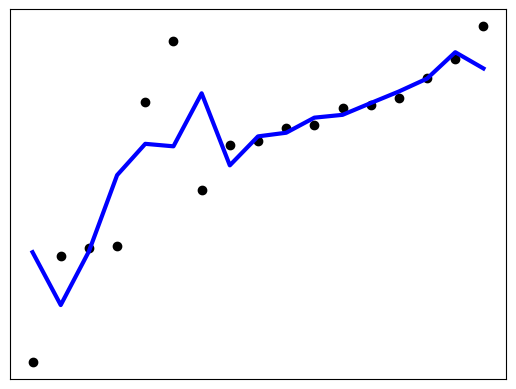

In [39]:
# K Nearest Neighbors Regression

# Option 1
# knnregr = neighbors.KNeighborsRegressor(n_neighbors=2, weights='uniform',metric='precomputed')

# X_dist = squareform(pdist(X), force='no', checks=True)
# X_dist[X_dist == 0 ] = 1000

# # Train the model using the training sets
# rnnregr.fit(X_dist, y)

# # Make predictions using the testing set
# y_pred = rnnregr.predict(X_dist)

# Option 2a
# knnregr = neighbors.KNeighborsRegressor(n_neighbors=2, weights='uniform',metric='euclidean')

# Option 2b
def d(a,b):
    if a==b: dist = 
    else: dist = abs(a-b)
    return dist
    
knnregr = neighbors.KNeighborsRegressor(n_neighbors=2, weights='uniform',metric=lambda a,b: d(a,b))

#Option 2
# Train the model using the training sets
knnregr.fit(X, y)

# Make predictions using the testing set
y_pred = knnregr.predict(X)



# Plot outputs
plt.scatter(X, y, color="black")
plt.plot(X, y_pred, color="blue", linewidth=3)
# plt.scatter(X, y_pred, color="blue")
plt.xticks(())
plt.yticks(())
plt.show()

In [40]:
# Check that KNN Reg is averaging y-values to left and right
for i in range(1,len(X)-1):
    if ((y[i-1]+y[i+1])/2) != y_pred[i]:
        print(i)

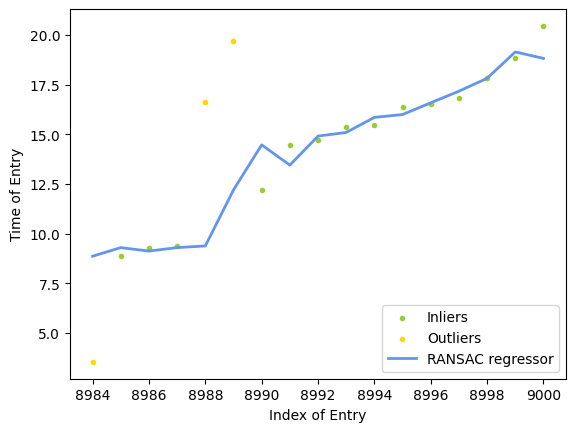

In [50]:
# Ransac wtih KNN

# https://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf

# ransac = linear_model.RANSACRegressor(estimator= linear_model.LinearRegression(),min_samples=None)

# Cannot use precomputed metric - messes up sampling in ransac
def d(a,b):
    if a==b: dist = 1000
    else: dist = abs(a-b)
    return dist
ransac = linear_model.RANSACRegressor(estimator= neighbors.RadiusNeighborsRegressor(radius=1.0, weights="uniform", metric=lambda a,b: d(a,b)),
                                      residual_threshold=2.5,min_samples=.7,max_trials=500)

# residual_threshold = maximum residual for a data sample to be classified as an inlier.

ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
y_pred = ransac.predict(X)

plt.scatter(X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
plt.scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers")
plt.plot(X, y_pred, color="cornflowerblue", linewidth=2,label="RANSAC regressor")
plt.legend(loc="lower right")
plt.xlabel("Index of Entry")
plt.ylabel("Time of Entry")
plt.show()

In [73]:
# Ransac, RNN (do not include self), multiple days

pdf = matplotlib.backends.backend_pdf.PdfPages("ransac_rnn_no_self.pdf")
def d(a,b):
    if a==b: dist = 1000
    else: dist = abs(a-b)
    return dist
ransac = linear_model.RANSACRegressor(estimator= neighbors.RadiusNeighborsRegressor(radius=1.0, weights="uniform", metric=lambda a,b: d(a,b)),
                                      residual_threshold=2.5,min_samples=.7,max_trials=1000, loss='absolute_error')
# ransac = linear_model.RANSACRegressor(estimator= linear_model.LinearRegression(),min_samples=None)

for j in range(10): # 37 is all days
    start_day = j*9

    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10, 7), layout="constrained",sharey=True)
    plt.setp(axs,yticks=np.arange(0,25,4))
    fig.suptitle('Log Number vs. Time of Day [0,24]')
    
    for i in range(9):
        col = i%3
        row = math.floor(i/3)
        df_regr = df_log[df_log['day']==start_day+i]
        X = np.array(df_regr['index']).reshape(-1, 1)
        y = np.array(df_regr['log_hour']).reshape(-1, 1)
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        y_pred = ransac.predict(X)
        axs[row, col].scatter(X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
        axs[row, col].scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers")
        axs[row, col].plot(X, y_pred, color="cornflowerblue", linewidth=2,label="RANSAC regressor")
        axs[row, col].set_xticks(np.arange(min(X), max(X)+1, 1.0))
        axs[row, col].set_xticklabels([])
        axs[row,col].set_title(start_day+i)
    
    # fig.show()
    # fig.savefig('test.pdf')
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

In [75]:
# Ransac, RNN (include self), multiple days

pdf = matplotlib.backends.backend_pdf.PdfPages("ransac_rnn_self.pdf")
ransac = linear_model.RANSACRegressor(estimator= neighbors.RadiusNeighborsRegressor(radius=1.0, weights="uniform", metric='euclidean'),
                                      residual_threshold=2.5,min_samples=.7,max_trials=1000, loss='absolute_error')

for j in range(20): # 37 is all days
    start_day = j*9

    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10, 7), layout="constrained",sharey=True)
    plt.setp(axs,yticks=np.arange(0,25,4))
    fig.suptitle('Log Number vs. Time of Day [0,24]')
    
    for i in range(9):
        col = i%3
        row = math.floor(i/3)
        df_regr = df_log[df_log['day']==start_day+i]
        X = np.array(df_regr['index']).reshape(-1, 1)
        y = np.array(df_regr['log_hour']).reshape(-1, 1)
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        y_pred = ransac.predict(X)
        axs[row, col].scatter(X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
        axs[row, col].scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers")
        axs[row, col].plot(X, y_pred, color="cornflowerblue", linewidth=2,label="RANSAC regressor")
        axs[row, col].set_xticks(np.arange(min(X), max(X)+1, 1.0))
        axs[row, col].set_xticklabels([])
        axs[row,col].set_title(start_day+i)
    
    # fig.show()
    # fig.savefig('test.pdf')
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

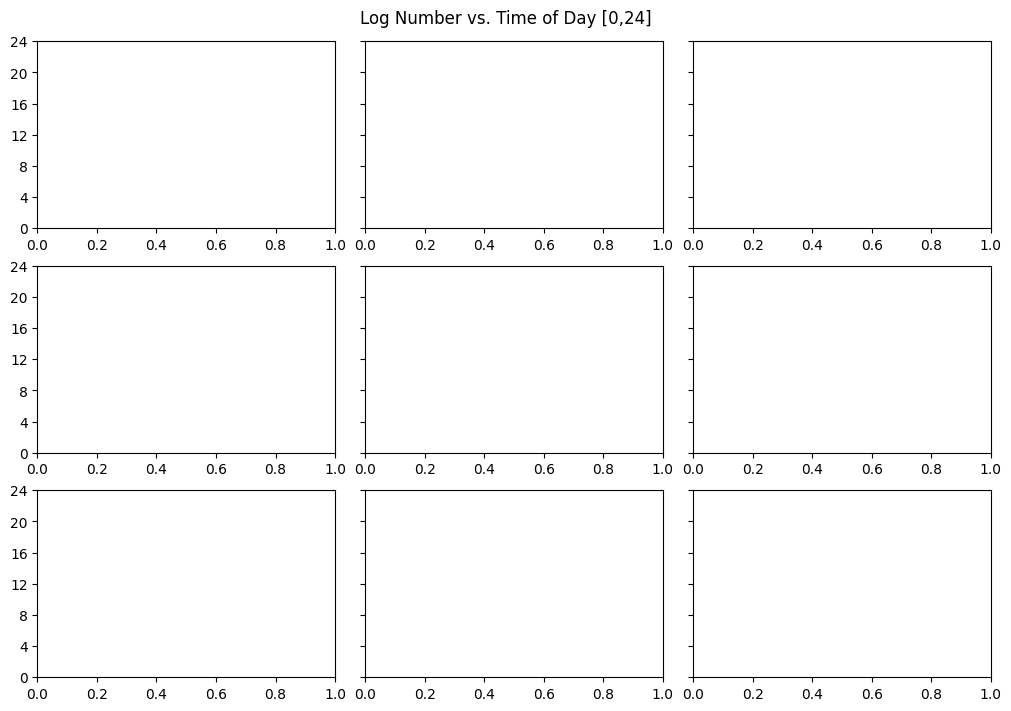

In [69]:
# RNN, multiple days

pdf = matplotlib.backends.backend_pdf.PdfPages("rnn_no_self.pdf")
def d(a,b):
    if a==b: dist = 1000
    else: dist = abs(a-b)
    return dist
rnnregr = neighbors.RadiusNeighborsRegressor(radius=1.1, weights="uniform", metric=lambda a,b: d(a,b))

for j in range(2):
    start_day = j*9

    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10, 7), layout="constrained",sharey=True)
    plt.setp(axs,yticks=np.arange(0,25,4))
    fig.suptitle('Log Number vs. Time of Day [0,24]')
    
    for i in range(9):
        col = i%3
        row = math.floor(i/3)
        df_regr = df_log[df_log['day']==start_day+i]
        X = np.array(df_regr['index']).reshape(-1, 1)
        y = np.array(df_regr['log_hour']).reshape(-1, 1)
        rnnregr.fit(X, y)
        y_pred = rnnregr.predict(X)
        inlier_mask = np.ndarray.flatten(abs(y - y_pred) < 2)
        outlier_mask = np.logical_not(inlier_mask)
        axs[row, col].scatter(X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Correct Time")
        axs[row, col].scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Erroneous Time")
        axs[row, col].plot(X, y_pred, color="cornflowerblue", linewidth=2,label="RNN regressor")
        axs[row, col].set_xticks(np.arange(min(X), max(X)+1, 1.0))
        axs[row, col].set_xticklabels([])
        axs[row,col].set_title(start_day+i)
    
    # fig.show()
    # fig.savefig('test.pdf')
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

In [72]:
# RNN (no self) via RANSAC to avoid error

pdf = matplotlib.backends.backend_pdf.PdfPages("test.pdf")
def d(a,b):
    if a==b: dist = 1000
    else: dist = abs(a-b)
    return dist
ransac = linear_model.RANSACRegressor(estimator= neighbors.RadiusNeighborsRegressor(radius=1.0, weights="uniform", metric=lambda a,b: d(a,b)),
                                      residual_threshold=10,min_samples=.99,max_trials=1000, loss='absolute_error')

for j in range(2): # 37 is all days
    start_day = j*9

    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10, 7), layout="constrained",sharey=True)
    plt.setp(axs,yticks=np.arange(0,25,4))
    fig.suptitle('Log Number vs. Time of Day [0,24]')
    
    for i in range(9):
        col = i%3
        row = math.floor(i/3)
        df_regr = df_log[df_log['day']==start_day+i]
        X = np.array(df_regr['index']).reshape(-1, 1)
        y = np.array(df_regr['log_hour']).reshape(-1, 1)
        ransac.fit(X, y)
        y_pred = ransac.predict(X)
        inlier_mask = np.ndarray.flatten(abs(y - y_pred) < 2)
        outlier_mask = np.logical_not(inlier_mask)
        axs[row, col].scatter(X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
        axs[row, col].scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers")
        axs[row, col].plot(X, y_pred, color="cornflowerblue", linewidth=2,label="RANSAC regressor")
        axs[row, col].set_xticks(np.arange(min(X), max(X)+1, 1.0))
        axs[row, col].set_xticklabels([])
        axs[row,col].set_title(start_day+i)
    
    # fig.show()
    # fig.savefig('test.pdf')
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

# Dates

In [21]:
idx = df[df['text5']=='Date:'].index
df['date'] = ''

pattern_date = re.compile("\d\d/\d\d/\d\d\d\d")
for i in idx:
    if pattern_date.fullmatch(df['text5'][i+1]):
        df['date'][i-1] = df['text5'][i+1]
    elif pattern_date.fullmatch(df['text5'][i-2]):
        df['date'][i-1] = df['text5'][i-2]

In [3]:
# df['date'].unique()
df['test'] = pd.to_datetime(df['date'], dayfirst=False, errors='coerce') # Not working for 01/13/2019
pd.to_datetime(df['date'][17989], dayfirst = True, errors='coerce') # Works for 01/13/2019

Timestamp('2019-01-13 00:00:00')

In [24]:
# pd.to_datetime(df['date'].unique(),errors='coerce')
date_df = df[df['date']!='']
dates_avail = pd.to_datetime(date_df['date'], dayfirst=False, errors='coerce').to_frame(name='date')
# date_df['test'] = pd.to_datetime(date_df['date'], dayfirst=False, errors='coerce')
dates_avail.shape

(314, 1)

In [28]:
dates_all = pd.Series(pd.date_range("2019", freq="d", periods=365)).to_frame(name='date2')
test = dates_all.merge(dates_avail, how = 'left', left_on = 'date2', right_on = 'date', suffixes=('_x', '_y'))
test[pd.isnull(test['date'])].shape

(65, 2)

# Days - Old

In [157]:
# Limit to lines with status words in case Arvd and Clrd are not consecutive 
df2 = df[df['status']!='']
df2 = df2.reset_index()

In [158]:
# log dataframe (each row is a log)
df3 = pd.DataFrame(columns =['arvd_time','clrd_time'])

idx = df2[df2['status']=='Arvd'].index
for i in idx:
    if df2['status'][i+1] == 'Clrd':
        df3 = pd.concat([df3, pd.DataFrame([[df2['time_clean'][i],df2['time_clean'][i+1]]], columns=df3.columns)], ignore_index=True)

In [159]:
# Limit to logs <2 hours
df4 = df3[(df3['clrd_time']-df3['arvd_time']<'0 days 02:00:00') & (df3['clrd_time']-df3['arvd_time']>'0 days 00:00:00')]
df4.reset_index(drop=True, inplace = True)

In [160]:
# Method 1
df4['daybreak'] = np.where(df4['arvd_time']-df4['arvd_time'].shift(1)<'-1 days 12:00:00', 1, 0)
df4['daybreak'][0] = 1

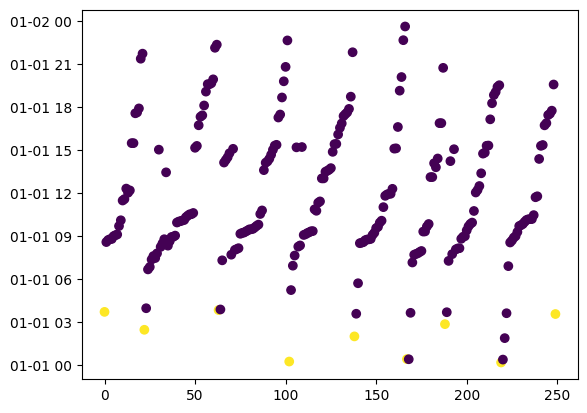

In [161]:
n = 250
plt.scatter(df4.index[0:250],df4['arvd_time'][0:250],c=df4['daybreak'][0:250])

In [162]:
df4['day']=0
for i in range(1,len(df4)):
    df4['day'][i] = df4['daybreak'][i] + df4['day'][i-1]

# Spectral Clustering for Days - Old

In [163]:
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

In [164]:
n = 6
df4['index']=df4.index
df4['arvd_time_int'] = pd.to_datetime(df4['arvd_time']).astype(np.int64)
X = df4[df4['day']<n][['index', 'arvd_time_int']]

In [165]:
# Preprocessing the data to make it visualizable 
  
# # Scaling the Data 
# scaler = StandardScaler() 
# X_scaled = scaler.fit_transform(X) 
  
# Normalizing the Data 
X_normalized = normalize(X) 
  
# Converting the numpy array into a pandas DataFrame 
X_principal = pd.DataFrame(X_normalized) 
  
X_principal.columns = ['index', 'arvd_time_int'] 

In [166]:
# NN
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = n, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal)

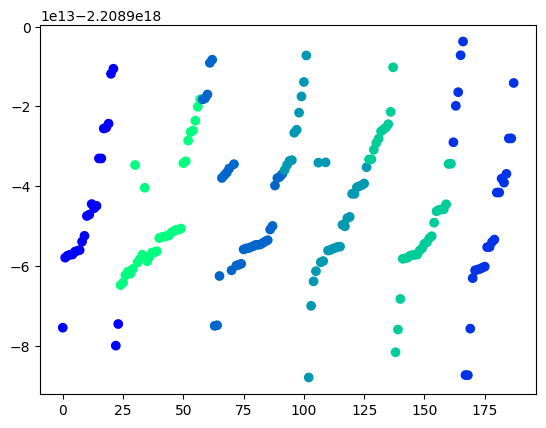

In [167]:
# Visualizing the clustering - Nearest Neighbors
plt.scatter(X['index'], X['arvd_time_int'],  
           c = SpectralClustering(n_clusters = n, affinity ='nearest_neighbors').fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

# Plot of arvd-clrd

In [108]:
# n = 50

# plt.figure(figsize=(13,9))
# plt.grid(which = 'both')
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# # plt.xlim(0,24)
# plt.ylim(-0.5,n+10)
# plt.xlabel('Time', fontsize = 16)

# bar_ys = list(range(n))
# bar_xs = df4[0:n].to_numpy().tolist()

# c = 'k'
# for y,xs in zip(bar_ys,bar_xs):
#     plt.annotate('', xy = (xs[0],y), xycoords='data', xytext=(xs[1],y),
#                  arrowprops=dict(arrowstyle='|-|', color=c, lw=2, shrinkA=0, shrinkB=0))
#     plt.annotate('',xy = (xs[1],y), xycoords='data', xytext=(-5,5), textcoords='offset points',
#                  fontsize = 16, va='baseline', ha='right', color=c)

# plt.show()

ValueError: xmin must be a single scalar value, but got 1900-01-01 03:42:00

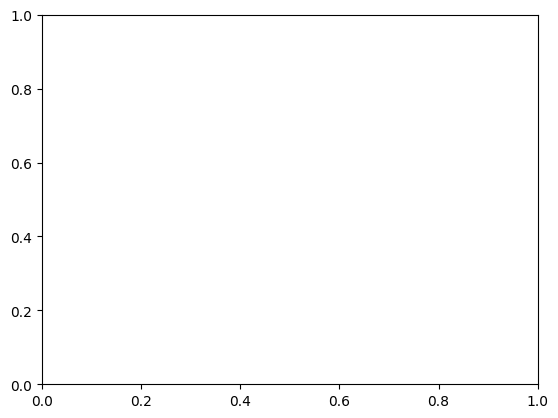

In [173]:
fig, ax = plt.subplots()
for i in df4.index:
    ax.axhline(y=i, xmin=df4.iloc[i,0], xmax=df4.iloc[i,1])

# Less Old

In [ ]:
# If text minus date/timestamp is similar to Arvd, Clrd, etc. --> clean

# If text Arvd/Clrd/etc-timestamp --> transit_time=timestamp

# If text Arvd/Clrd/ect-date and next line is @ and next line is timestamp --> transit_time[i]=timestamp[i+2]

# If text in Arvd, Clrd, etc. but no timestamp and next line is timestamp --> transit_time[i]=timestamp[i+1] 

In [281]:
# If text minus date/timestamp is similar to Arvd, Clrd, etc. --> clean

fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']
pattern = re.compile("\d\d[:/]\d\d[:/]\d\d+")

# New columns
df['text2'] = df['text']

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-', 'Axyvd-']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

for i in range(len(df)):
    for s in fix_list:
        if enchant.utils.levenshtein(re.sub(pattern,"",df['text'][i]),s)<=2:
            df['text2'][i] = df['text'][i].replace(re.sub(pattern,"",df['text'][i]),s)
            
    if re.sub(pattern,"",df['text'][i]) in manual_arvd:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Arvd-',df['text'][i])

    if re.sub(pattern,"",df['text'][i]) in manual_clrd:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Clrd-',df['text'][i])

    if re.sub(pattern,"",df['text'][i]) in manual_enrt:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Enrt-',df['text'][i])

df[df['text']!=df['text2']]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text2
308,5,1,20,1,1,1,867,350,286,51,87,Bnrt-11:24:07,3,Enrt-11:24:07
1593,5,1,29,1,1,1,1195,1125,292,51,0,Arvad-08:46:35,7,Arvd-08:46:35
1629,5,1,32,2,1,2,1537,1725,288,52,52,Clird-08:28:55,7,Clrd-08:28:55
1796,5,1,9,1,1,1,1189,725,292,50,0,Arv@a-08:56:46,8,Arvd-08:56:46
1797,5,1,9,1,1,2,1532,725,290,51,86,Cird-08:57:22,8,Clrd-08:57:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583673,5,1,34,1,1,1,1184,1400,288,51,62,Brvd-15:08:29,2370,Arvd-15:08:29
583674,5,1,34,1,1,2,1522,1400,285,51,25,Cird-15:11:34,2370,Clrd-15:11:34
584006,5,1,26,4,1,4,1554,1950,286,55,31,Clrdg-17:40:39,2371,Clrd-17:40:39
584008,5,1,26,4,1,2,882,1975,288,55,16,Bnrt-17:21:15,2371,Enrt-17:21:15


## Old

In [6]:
# Merge timestamps without text with preceding row

# New columns
df['text_merge']=df['text']
df['discard']=0

pattern = re.compile("\d\d:\d\d:\d\d")

for i in range(len(df)-1):
    if pattern.match(df['text'][i+1]): #Checks for timestamp at front
        df['text_merge'][i] = df['text'][i]+df['text'][i+1]
        df['discard'][i+1]=1

In [7]:
# Fix timestamp words
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']
pattern = re.compile("\d\d:\d\d:\d\d")

# New columns
df['text2'] = df['text_merge']
df['timestamp'] =''
df['text_alpha'] = ''

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-', 'Axyvd-1']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_disp = ['$p-']
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

for i in range(len(df)):
# Run for loop on lines with criteria
    if pattern.search(df['text_merge'][i]): #Checks for timestamp anywhere in text
        df['timestamp'][i] = pattern.search(df['text_merge'][i])[0]
        for s in fix_list:
            if (enchant.utils.levenshtein(re.sub(pattern,"",df['text_merge'][i]),s)<=2):
                df['text2'][i] = s + pattern.search(df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_arvd:
        df['text2'][i] = 'Arvd-' + pattern.search(df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_clrd:
        df['text2'][i] = 'Clrd-' + re.search(pattern,df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_enrt:
        df['text2'][i] = 'Enrt-' + re.search(pattern,df['text_merge'][i])[0]

    df['text_alpha'][i] = re.sub(pattern,"",df['text2'][i])

# Check
df_ts = df[df['timestamp']!='']
df_ts['text_alpha'].value_counts()
# df_ts['text_alpha'].unique()

# Note - dist('Arvd','Clrd') = 3 so threshhold needs to be 2

text_alpha
Clrd-        12149
Arvd-        11709
Disp-         3148
Enrt-         2353
                97
@               47
©                3
-                2
21A0G2019        1
21AUG2019        1
©@               1
Name: count, dtype: int64

In [38]:
# Example of a merge fix
df.iloc[11025:11027] #2019

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text_merge,discard,text2,timestamp,text_alpha
11025,5,1,73,1,1,1,1186,2400,106,49,91,Arvd-,45,Arvd-08:32:54,0,Arvd-08:32:54,08:32:54,Arvd-
11026,5,1,73,1,1,2,1303,2400,173,48,96,08:32:54,45,08:32:54,1,08:32:54,08:32:54,


In [16]:
# df[(df['text_merge']!=df['text2']) and (df['text_alpha']==" ")]
# # df[(df['text']!=df['text_merge'])]
# # df.iloc[7619:7623] #2019 Clrd-date
# # # df.iloc[16806:16809] #2019
# # # df[df['text']=='@']
# # # df.iloc[435:446]

df.iloc[7615:7630]
df[df['text_alpha']==""]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text_merge,discard,text2,timestamp,text_alpha
7621,5,1,10,1,10,1,12,1375,173,50,96,00:01:00,32,00:01:00,1,00:01:00,00:01:00,
11026,5,1,73,1,1,2,1303,2400,173,48,96,08:32:54,45,08:32:54,1,08:32:54,08:32:54,
12325,5,1,26,3,1,3,1644,2500,175,49,96,03:33:06,50,03:33:06,1,03:33:06,03:33:06,
16808,5,1,3,1,4,1,14,150,172,51,95,00:02:20,69,00:02:20,1,00:02:20,00:02:20,
18907,5,1,20,1,1,1,0,2525,171,50,95,00:02:58,78,00:02:58,1,00:02:58,00:02:58,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570643,5,1,3,1,1,1,4,475,172,49,90,00:34:05,2314,00:34:05,1,00:34:05,00:34:05,
570649,5,1,3,2,1,1,4,600,172,47,52,00:24:54,2314,00:24:54,1,00:24:54,00:24:54,
573422,5,1,15,1,1,1,4,2075,172,49,93,00:03:39,2325,00:03:39,1,00:03:39,00:03:39,
580179,5,1,1,1,35,1,2,1750,172,49,95,00:01:22,2354,00:01:22,1,00:01:22,00:01:22,


In [19]:
# df[df['text']=='@'].shape # 1% of text (5,980 rows) is '@'
# df[df['text']=='@']['text_merge'].value_counts() # Most (5,933) @ not followed by timestamp
# When @ followed by timestamp, it is usually clrd-date @ time (just after midnight). Example:
df.iloc[7618:7623] #2019

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,date
7618,5,1,10,1,9,1,1201,1325,291,52,76,Arvd-23:56:15,32,0
7619,5,1,10,1,9,2,1543,1325,335,57,76,Clrd-01/06/2019,32,1
7620,5,1,10,1,9,3,1903,1350,22,47,92,@,32,0
7621,5,1,10,1,10,1,12,1375,173,50,96,00:01:00,32,0
7622,5,1,10,1,11,1,255,1400,170,50,96,Vehicle:,32,0


In [180]:
# Pair Arvd & Clrd.
# 2019 dataset: df_arvd is 11,707, df_clrd is 12,148
# Idea: Pair arvd with next clrd. Pair clrd with the arvd that was assigned to it.

df_arvd = df[df['text_alpha']=='Arvd-']
df_clrd = df[df['text_alpha']=='Clrd-']

# for i in df_arvd.index:
#     # Set df['time_clrd'][i] to next occurence in df[beyond row i] of clrd

# df[df['timestamp']>'24:00:00'].head(20)
# df[df['timestamp']!=''].head(20)

(12148, 16)

In [ ]:
# Next step: Text clustering with k-means
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
# Center = most frequent spelling?

In [95]:
# # Strings that end in hh:mm:ss
# pattern = re.compile("\d\d:\d\d:\d\d")
# timestamp_words = []
# for i in range(len(df)):
#     if pattern.search(df['text'][i]):
#         timestamp_words.append(re.sub(pattern,"",df['text'][i]))

# timestamp_words = pd.DataFrame(timestamp_words)
# timestamp_words[0].unique()